In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.api import Logit
import patsy
from joblib import load, dump

import model_functions as mf
import eval_measures as ems

from IPython.display import display

MF reloaded 1
EMS reloaded


In [2]:
MODEL_VERSION = "v4.reviewer"
MODEL_SUFFIX = "%s.first_author" % MODEL_VERSION
GENDERS = ["-", "F", "M"]
TOP_15_ETHNICITIES = ["ENGLISH", "GERMAN", "HISPANIC", "CHINESE",
                      "JAPANESE", "SLAV", "FRENCH", "ITALIAN", "INDIAN",
                      "NORDIC", "ARAB", "DUTCH", "KOREAN", "UNKNOWN", "OTHER"]
TOP_15_COUNTRIES = ["USA", "UNKNOWN", "UK", "JAPAN", "GERMANY", "FRANCE", "ITALY",
                    "CANADA", "CHINA", "AUSTRALIA", "SPAIN", "NETHERLANDS",
                    "SWEDEN", "INDIA", "OTHER"]

sns.set_context("poster")
sns.set_style("ticks")

In [3]:
def filtered_data(df, max_source_ncites=100, version=1):
    # Base version 1
    df_filtered = df[(df.source_country == "USA")
                & (df.source_is_eng)
                & (df.source_is_journal)
                & (df.source_ncites >= 10)
                & (df.source_ncites <=max_source_ncites)]
    if version == 2:
        df_filtered = df_filtered[(df.eth1 == "ENGLISH")
                & (df.eth2 == "UNKNOWN")]
    print df_filtered.shape, df.shape
    return df_filtered


def fit_model(df, base_formula, include_prc=True, MODEL_VERSION="v4", MODEL_SUFFIX="", version=1):
    results_full = []
    nrows, ncols = 1,1
    figsize = 5
    if include_prc:
        fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True,
                               squeeze=False, figsize=(ncols*figsize, nrows*figsize))
        fig1, ax1 = plt.subplots(nrows, ncols, sharex=True, sharey=True,
                                 squeeze=False, figsize=(ncols*figsize, nrows*figsize))
        print "Created figure with %s rows and %s columns" % (nrows, ncols)
        ax = ax.flatten()
        ax1 = ax1.flatten()

    formula = base_formula
    i = 0
    measures, summary = model_fit(df, formula, include_prc=include_prc)

    prc = measures.pop("prc", None)
    roc = measures.pop("roc", None)
    if include_prc and prc is not None and roc is not None:
        ## PRC
        plot_prc(prc, ax=ax[i], color="k")
        ax[i].plot([measures["recall"]], [measures["precision"]], marker="o",
                   color="k", linestyle="none", ms=15)
        ax[i].plot([0,1], [1,0], "--k", linewidth=1)
        ax[i].set_xlabel("Recall")
        ax[i].set_ylabel("Precision")
        ## ROC
        plot_prc(roc, ax=ax1[i], color="k")
        ax1[i].plot([measures["fpr"]], [measures["tpr"]], marker="o",
                   color="k", linestyle="none", ms=15)
        ax1[i].plot([0,1], [0,1], "--k", linewidth=1)
        ax1[i].set_xlabel("False Positive Rate")
        ax1[i].set_ylabel("True Positive Rate")
    print measures
    print display(summary)
    results_full.append(("all", (measures, summary)))

    if include_prc:
        fig.tight_layout()
        fig.savefig("PRC_model.%s.filtered_%s.pdf" % (MODEL_SUFFIX, version), bbox_inches="tight")
        fig1.tight_layout()
        fig1.savefig("ROC_model.%s.filtered_%s.pdf" % (MODEL_SUFFIX, version), bbox_inches="tight")
        
    dump([results_full],
         "results_all_model/%s/results_all_model.%s.filtered_%s.pkl" % (MODEL_VERSION, MODEL_SUFFIX, version))
    return [results_full]

## Load Data

In [4]:
%%time
with pd.HDFStore('out/ModelData.20170303.h5') as cstore:
    df_fa = cstore['first_author']
    df_la = cstore['last_author']

CPU times: user 6min 6s, sys: 2min 30s, total: 8min 36s
Wall time: 8min 36s


In [5]:
df_fa.head()

,source_id,source_year,source_n_mesh,source_n_mesh_ex,source_is_eng,source_country,source_is_journal,source_is_review,source_is_case_rep,source_is_let_ed_com,...,jj_sim,is_self_cite,first_year,last_year,au_age,match_len,match_prop,overall_coverage_len,overall_coverage_prop,eth_weight
0,16526454,2005,11,53,True,JAPAN,True,False,False,False,...,14.6053,0,1982,2009,23,47.0,0.886792,47.0,0.886792,1.0
1,16526454,2005,11,53,True,JAPAN,True,False,False,False,...,14.6053,1,1982,2009,23,47.0,0.886792,47.0,0.886792,1.0
2,14595765,2003,17,71,True,JAPAN,True,False,False,False,...,0.0000,0,1998,2009,5,47.0,0.661972,67.0,0.943662,1.0
3,14595765,2003,17,71,True,JAPAN,True,False,False,False,...,5.5691,0,1998,2009,5,47.0,0.661972,67.0,0.943662,1.0
4,14595765,2003,17,71,True,JAPAN,True,False,False,False,...,5.5691,0,1998,2009,5,47.0,0.661972,67.0,0.943662,1.0


In [6]:
df_fa.columns

Index([u'source_id', u'source_year', u'source_n_mesh', u'source_n_mesh_ex',
       u'source_is_eng', u'source_country', u'source_is_journal',
       u'source_is_review', u'source_is_case_rep', u'source_is_let_ed_com',
       u'source_T_novelty', u'source_V_novelty', u'source_PT_novelty',
       u'source_PV_novelty', u'source_ncites', u'source_n_authors', u'sink_id',
       u'sink_year', u'sink_n_mesh', u'sink_n_mesh_ex', u'sink_is_eng',
       u'sink_is_journal', u'sink_is_review', u'sink_is_case_rep',
       u'sink_is_let_ed_com', u'sink_T_novelty', u'sink_V_novelty',
       u'sink_PT_novelty', u'sink_PV_novelty', u'sink_n_authors', u'year_span',
       u'journal_same', u'mesh_sim', u'title_sim', u'lang_sim',
       u'affiliation_sim', u'pubtype_sim', u'cite_sim', u'author_sim',
       u'gender_sim', u'eth_sim', u'n_common_authors', u'gender', u'eth1',
       u'eth2', u'pos', u'pos_nice', u'sink_last_ncites', u'sink_prev_ncites',
       u'auth_last_npapers', u'auth_prev_papers', u'jj_

In [7]:
def plot_prc(prc, ax, color="k", label="PRC"):
    precision, recall = prc
    ax.plot(recall, precision, 
            marker="None", linestyle="-",
            color=color, label=label)

def get_all_eval_measures(predict, endog, include_prc=False):
    measures = {}
    pred_table = ems.cm(predict, endog)
    measures["precision"] = ems.precision(pred_table)
    measures["recall"] = ems.recall(pred_table)
    measures["accuracy"] = ems.accuracy(pred_table)
    measures["f_score"] = ems.fscore_measure(pred_table)
    measures["rmse"] = ems.rmse(predict, endog)
    measures["mae"] = ems.mae(predict, endog)
    measures["auc"] = ems.auc(predict, endog)
    tn, fp, fn, tp = map(float, pred_table.flatten()) # WRT to 1 as positive label
    measures["tn"] = tn
    measures["fn"] = fn
    measures["fp"] = fp
    measures["tp"] = tp
    measures["tpr"] = tp * 1. / (tp + fn) 
    measures["fpr"] = fp * 1. / (fp + tn) 
    print "In eval measures function."
    if include_prc:
        ## Include the precision recall values
        prc = ems.prc(predict, endog, float_precision=3)
        measures["prc"] = prc
        roc = ems.roc(predict, endog, float_precision=3)
        measures["roc"] = roc
    return measures


def model_fit(df, formula, testing=False, include_prc=False):
    if testing:
        # If testing the just print X and y columns
        print df.shape, formula, include_prc
        return ({"llf": 0.1}, "TEMP SUMMARY")
    ## Not testing. Fit the models and return the measures
    print df.shape, formula, include_prc
    y,X = patsy.dmatrices(formula, data=df, return_type="dataframe")
    print "Created dataframes"
    print "X.shape = %s, y.shape = %s" % (X.shape, y.shape)
    model = Logit(y,X)
    res = model.fit()
    predict = res.predict()
    measures = get_all_eval_measures(predict, model.endog, include_prc=include_prc)
    measures["llf"] = res.llf
    measures["aic"] = res.aic
    measures["bic"] = res.bic
    measures["prsquared"] = res.prsquared
    measures["df_model"] = res.df_model
    return (measures, res.summary2())


def print_model(results_filtered, fp):
    columns = ["llf", "aic", "bic", "prsquared", "df_model",
               "precision", "recall", "f_score", "auc", "mae",
               "rmse", "tp", "fp", "tn", "fn", "tpr", "fpr"]
    measures = pd.DataFrame(columns=columns)
    for j,(m,s) in results_filtered[0]:
        print >> fp, "%s\t%s\t%s" % ("*"*50, j, "*"*50)
        measures.ix[j,columns] = [m[k] for k in columns]
        print >> fp, s
    print >> fp, "%s\t%s\t%s" % ("*"*50, "All Measures", "*"*50)
    print >> fp, measures.to_string()

## Fit models version 1

**Filters applied**
* au_age = 10
* source_ncites = [10,60]

In [8]:
def filtered_data(df, max_source_ncites=100, version=1):
    # Base version 1
    df_filtered = df[(df.au_age >= 8)
                & (df.au_age <= 12)
                & (df.source_ncites >= 10)
                & (df.source_ncites <=max_source_ncites)]
    print df_filtered.shape, df.shape
    print "Filter dataset is %.2f%% of the original data." % (df_filtered.shape[0] * 100./df.shape[0])
    return df_filtered

In [9]:
base_formula = ("is_self_cite ~ "
            #"I(auth_prev_papers == 0)"
           "+ I(auth_prev_papers == 1)"
           "+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)"
           "+ C(gender, levels=GENDERS) + C(source_country, levels=TOP_15_COUNTRIES)"
           "+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"
           #"+ I(source_ncites == 1)"
           "+ np.log10(source_ncites)"
           "+ I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)"
           "+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))"
           "+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)"
           "+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)" 
           "+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)"
           "+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)"
           "+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)"
           "+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same"
           "+ source_is_eng + source_is_journal + source_is_review + source_is_case_rep + source_is_let_ed_com"
           "+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com"
           "+ np.log10(np.nan_to_num(source_V_novelty) + 1)"
           "+ np.log10(np.nan_to_num(sink_V_novelty) + 1) + I(np.log10(np.nan_to_num(sink_V_novelty) + 1)**2)"
          )

version = 1

### First author

In [10]:
%%time
df_filtered = filtered_data(df_fa, max_source_ncites=60, version=version)

(9677944, 61) (83238480, 61)
Filter dataset is 11.63% of the original data.
CPU times: user 6.85 s, sys: 3.82 s, total: 10.7 s
Wall time: 10.7 s


Created figure with 1 rows and 1 columns
(9677944, 61) is_self_cite ~ + I(auth_prev_papers == 1)+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)+ C(gender, levels=GENDERS) + C(source_country, levels=TOP_15_COUNTRIES)+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)+ np.log10(source_ncites)+ I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same+ source_is_eng + source_is_journal + source_is_review + source_is_case_rep + source_is_l

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                     Results: Logit
=========================================================================================================================
Model:                                Logit                              Pseudo R-squared:                   0.183       
Dependent Variable:                   is_self_cite                       AIC:                                3496984.1301
Date:                                 2017-03-10 15:50                   BIC:                                3497941.9346
No. Observations:                     9677944                            Log-Likelihood:                     -1.7484e+06 
Df Model:                             67                                 LL-Null:                            -2.1393e+06 
Df Residuals:                         9677876                            LLR p-value:                        0.0000      
Converged:                            1.0000                             Scale:                              1.0000      
No. Iterations:                       10.0000                                                                            
-------------------------------------------------------------------------------------------------------------------------
                                                                      Coef.   Std.Err.     z     P>|z|   [0.025   0.975] 
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                              1.1848   0.4662    2.5411 0.0111   0.2710   2.0986
I(auth_prev_papers == 1)[T.True]                                      -0.7097   0.0406  -17.4646 0.0000  -0.7894  -0.6301
C(gender, levels=GENDERS)[T.F]                                        -0.0353   0.0062   -5.7392 0.0000  -0.0474  -0.0233
C(gender, levels=GENDERS)[T.M]                                        -0.0496   0.0057   -8.6929 0.0000  -0.0608  -0.0384
C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]                  0.0344   0.0130    2.6454 0.0082   0.0089   0.0598
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]                       0.0694   0.0061   11.2877 0.0000   0.0573   0.0814
C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]                    0.3979   0.0108   36.6874 0.0000   0.3767   0.4192
C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]                  0.0944   0.0075   12.6318 0.0000   0.0798   0.1091
C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]                  -0.0405   0.0099   -4.1080 0.0000  -0.0598  -0.0212
C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]                    0.0269   0.0120    2.2424 0.0249   0.0034   0.0503
C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]                  -0.0093   0.0084   -1.0962 0.2730  -0.0258   0.0073
C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]                   -0.4627   0.0224  -20.6218 0.0000  -0.5067  -0.4187
C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]                0.1637   0.0098   16.7373 0.0000   0.1445   0.1829
C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]                   -0.0809   0.0116   -6.9534 0.0000  -0.1037  -0.0581
C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]              0.1342   0.0135    9.9436 0.0000   0.1077   0.1607
C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]                   0.1634   0.0126   12.9740 0.0000   0.1387   0.1881
C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]                   -0.0038   0.0237   -0.1585 0.8740  -0.0502   0.0427
C(source_country, levels=TOP_15_COUNTRIES)[T.OTHER]                   -0.0194   0.0049   -3.9673 0.0001  -0.0290  -0.0098
I(source_n_authors > 20)[T.True]                                       0.0984   0.0266    3.6943 0.0002   0.0462   0.1506
I(source_n_mesh_ex == 0)[T.True]                                      -0.9388   0.0265  -35.4220 0.00

None


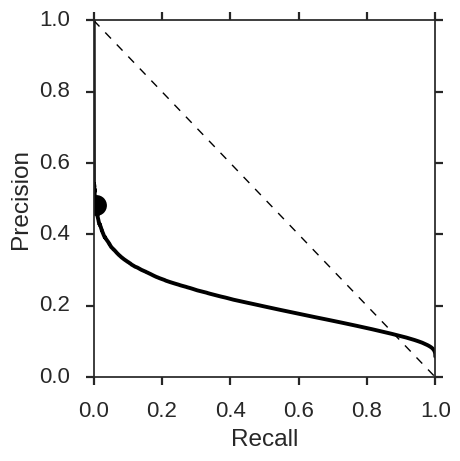

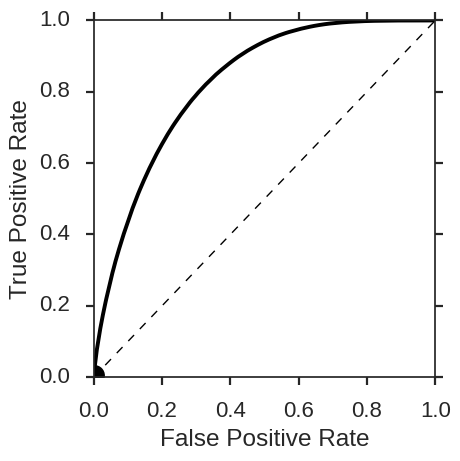

In [11]:
MODEL_SUFFIX = "%s.first_author" % MODEL_VERSION

results_full = fit_model(df_filtered, base_formula, include_prc=True,
                            MODEL_VERSION=MODEL_VERSION, MODEL_SUFFIX=MODEL_SUFFIX, version=version)

In [12]:
results_filtered = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" 
                        % (MODEL_VERSION, MODEL_SUFFIX, version))
with open("Filtered_models.%s.filtered_%s.txt" % (MODEL_SUFFIX, version), "wb+") as fp: 
    print_model(results_filtered, fp)

### Last author

In [13]:
%%time
df_filtered_la = filtered_data(df_la, max_source_ncites=60, version=version)

(8632368, 61) (83238534, 61)
Filter dataset is 10.37% of the original data.
CPU times: user 6.23 s, sys: 2.77 s, total: 9 s
Wall time: 9.01 s


Created figure with 1 rows and 1 columns
(8632368, 61) is_self_cite ~ + I(auth_prev_papers == 1)+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)+ C(gender, levels=GENDERS) + C(source_country, levels=TOP_15_COUNTRIES)+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)+ np.log10(source_ncites)+ I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same+ source_is_eng + source_is_journal + source_is_review + source_is_case_rep + source_is_l

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                     Results: Logit
=========================================================================================================================
Model:                                Logit                              Pseudo R-squared:                   0.153       
Dependent Variable:                   is_self_cite                       AIC:                                3918971.1326
Date:                                 2017-03-10 15:58                   BIC:                                3919921.1626
No. Observations:                     8632368                            Log-Likelihood:                     -1.9594e+06 
Df Model:                             67                                 LL-Null:                            -2.3129e+06 
Df Residuals:                         8632300                            LLR p-value:                        0.0000      
Converged:                            1.0000                             Scale:                              1.0000      
No. Iterations:                       10.0000                                                                            
-------------------------------------------------------------------------------------------------------------------------
                                                                      Coef.   Std.Err.     z     P>|z|   [0.025   0.975] 
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                              2.2028   0.4372    5.0384 0.0000   1.3459   3.0597
I(auth_prev_papers == 1)[T.True]                                      -0.5754   0.0572  -10.0538 0.0000  -0.6876  -0.4633
C(gender, levels=GENDERS)[T.F]                                        -0.0371   0.0059   -6.2782 0.0000  -0.0487  -0.0255
C(gender, levels=GENDERS)[T.M]                                        -0.0468   0.0052   -9.0524 0.0000  -0.0569  -0.0367
C(source_country, levels=TOP_15_COUNTRIES)[T.UNKNOWN]                 -0.1037   0.0124   -8.3587 0.0000  -0.1281  -0.0794
C(source_country, levels=TOP_15_COUNTRIES)[T.UK]                       0.0019   0.0054    0.3459 0.7294  -0.0087   0.0125
C(source_country, levels=TOP_15_COUNTRIES)[T.JAPAN]                    0.0049   0.0137    0.3547 0.7228  -0.0221   0.0318
C(source_country, levels=TOP_15_COUNTRIES)[T.GERMANY]                 -0.0465   0.0065   -7.1383 0.0000  -0.0593  -0.0338
C(source_country, levels=TOP_15_COUNTRIES)[T.FRANCE]                  -0.0344   0.0094   -3.6772 0.0002  -0.0528  -0.0161
C(source_country, levels=TOP_15_COUNTRIES)[T.ITALY]                   -0.1149   0.0136   -8.4272 0.0000  -0.1416  -0.0882
C(source_country, levels=TOP_15_COUNTRIES)[T.CANADA]                  -0.0732   0.0074   -9.8850 0.0000  -0.0877  -0.0587
C(source_country, levels=TOP_15_COUNTRIES)[T.CHINA]                   -0.5470   0.0117  -46.9097 0.0000  -0.5699  -0.5242
C(source_country, levels=TOP_15_COUNTRIES)[T.AUSTRALIA]               -0.0389   0.0092   -4.2145 0.0000  -0.0570  -0.0208
C(source_country, levels=TOP_15_COUNTRIES)[T.SPAIN]                   -0.0855   0.0115   -7.4247 0.0000  -0.1081  -0.0629
C(source_country, levels=TOP_15_COUNTRIES)[T.NETHERLANDS]             -0.0627   0.0129   -4.8550 0.0000  -0.0880  -0.0374
C(source_country, levels=TOP_15_COUNTRIES)[T.SWEDEN]                   0.0181   0.0114    1.5827 0.1135  -0.0043   0.0404
C(source_country, levels=TOP_15_COUNTRIES)[T.INDIA]                   -0.0323   0.0192   -1.6823 0.0925  -0.0700   0.0053
C(source_country, levels=TOP_15_COUNTRIES)[T.OTHER]                   -0.1702   0.0045  -37.4087 0.0000  -0.1791  -0.1613
I(source_n_authors > 20)[T.True]                                      -0.0417   0.0278   -1.4975 0.1343  -0.0963   0.0129
I(source_n_mesh_ex == 0)[T.True]                                      -0.7730   0.0222  -34.7774 0.00

None
CPU times: user 32min 47s, sys: 3min 56s, total: 36min 43s
Wall time: 8min 47s


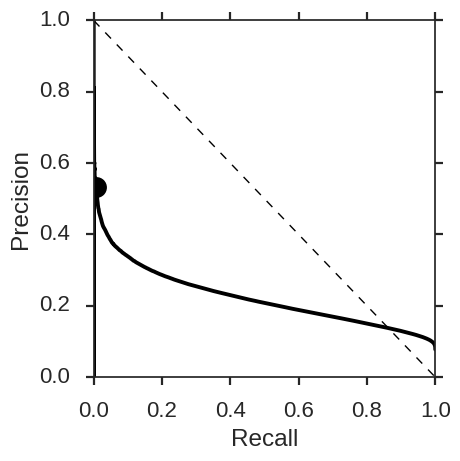

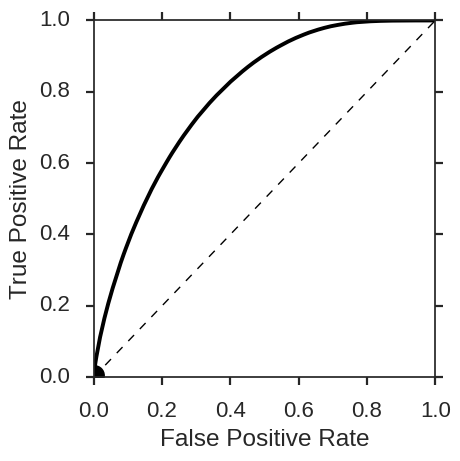

In [14]:
%%time
MODEL_SUFFIX = "%s.last_author" % MODEL_VERSION

results_full = fit_model(df_filtered_la, base_formula, include_prc=True,
                            MODEL_VERSION=MODEL_VERSION, MODEL_SUFFIX=MODEL_SUFFIX, version=version)

In [15]:
results_filtered = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" 
                        % (MODEL_VERSION, MODEL_SUFFIX, version))
with open("Filtered_models.%s.filtered_%s.txt" % (MODEL_SUFFIX, version), "wb+") as fp: 
    print_model(results_filtered, fp)

## Final full filtered dataset

In [16]:
def filtered_data(df, max_source_ncites=100, version=1):
    # Base version 1
    df_filtered = df[(df.gender != "-")
                & (df.source_ncites >= 10)
                & (df.source_ncites <=max_source_ncites)]
    print df_filtered.shape, df.shape
    print "Filter dataset is %.2f%% of the original data." % (df_filtered.shape[0] * 100./df.shape[0])
    return df_filtered

In [17]:
GENDERS_NO_UNK=["M", "F"]

In [18]:
base_formula = ("is_self_cite ~ "
            "I(auth_prev_papers == 0)"
           "+ I(auth_prev_papers == 1)"
           "+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)"
           "+ C(gender, levels=GENDERS_NO_UNK) + C(source_country, levels=TOP_15_COUNTRIES)"
           "+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"
           #"+ I(source_ncites == 1)"
           "+ np.log10(source_ncites)"
           "+ I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)"
           "+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))"
           "+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)"
           "+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)" 
           "+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)"
           "+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)"
           "+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)"
           "+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same"
           "+ source_is_eng + source_is_journal + source_is_review + source_is_case_rep + source_is_let_ed_com"
           "+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com"
           "+ np.log10(np.nan_to_num(source_V_novelty) + 1)"
           "+ np.log10(np.nan_to_num(sink_V_novelty) + 1) + I(np.log10(np.nan_to_num(sink_V_novelty) + 1)**2)"
          )
version = "full_filtered"

## First author

In [ ]:
%%time
df_filtered_fa = filtered_data(df_fa, max_source_ncites=60, version=version)

(52297350, 61) (83238480, 61)
Filter dataset is 62.83% of the original data.
CPU times: user 15.8 s, sys: 11.6 s, total: 27.4 s
Wall time: 27.4 s


In [ ]:
%%time
MODEL_SUFFIX = "%s.first_author" % MODEL_VERSION

results_full = fit_model(df_filtered_fa, base_formula, include_prc=True,
                            MODEL_VERSION=MODEL_VERSION, MODEL_SUFFIX=MODEL_SUFFIX, version=version)

Created figure with 1 rows and 1 columns
(52297350, 61) is_self_cite ~ I(auth_prev_papers == 0)+ I(auth_prev_papers == 1)+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)+ C(gender, levels=GENDERS_NO_UNK) + C(source_country, levels=TOP_15_COUNTRIES)+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)+ np.log10(source_ncites)+ I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same+ source_is_eng + source_is_journal + source_is_review + 

In [ ]:
results_filtered = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" 
                        % (MODEL_VERSION, MODEL_SUFFIX, version))
with open("Filtered_models.%s.filtered_%s.txt" % (MODEL_SUFFIX, version), "wb+") as fp: 
    print_model(results_filtered, fp)

### Last author

In [ ]:
%%time
df_filtered_la = filtered_data(df_la, max_source_ncites=60, version=version)

In [ ]:
%%time
MODEL_SUFFIX = "%s.last_author" % MODEL_VERSION

results_full = fit_model(df_filtered_la, base_formula, include_prc=True,
                            MODEL_VERSION=MODEL_VERSION, MODEL_SUFFIX=MODEL_SUFFIX, version=version)

In [ ]:
results_filtered = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" 
                        % (MODEL_VERSION, MODEL_SUFFIX, version))
with open("Filtered_models.%s.filtered_%s.txt" % (MODEL_SUFFIX, version), "wb+") as fp: 
    print_model(results_filtered, fp)

# Filter by journal

In [ ]:
JOURNAL_NAMES  = dict(
    MEDICINE = set(['JAMA', 'Lancet', 'N Engl J Med']),
    BIOLOGY = set(['J Biol Chem', 'Cell',  'Adv Exp Med Biol']), 
    BIOINFORMATICS=set(['BMC Bioinformatics', 'Bioinformatics', 'Bioinformation', 'PLoS Comput Biol']),
    GENERIC=set(['Proc Natl Acad Sci U S A', 'Nature', 'Science', 'PLoS One'])
)
JOURNAL_PMIDS = dict()
with pd.HDFStore('out/JOURNAL_PMIDS.20170303.h5') as cstore:
    for k in JOURNAL_NAMES:
        JOURNAL_PMIDS[k] = set(cstore[k].values.tolist())
        print k, len(JOURNAL_PMIDS[k])

In [ ]:
%%time
df_filtered = df_fa[df_fa.source_id.isin(JOURNAL_PMIDS["MEDICINE"])]
print df_filtered.shape

In [ ]:
base_formula = ("is_self_cite ~ I(auth_prev_papers == 1) "
           "+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)"
           "+ C(gender, levels=GENDERS)"
           "+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"
           "+ np.log10(source_ncites) "
           "+ I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)"
           "+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))"
           "+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)"
           "+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)" 
           "+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)"
           "+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)"
           "+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)"
           "+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same"
           "+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com"
           "+ np.log10(np.nan_to_num(source_V_novelty) + 1)"
           "+ np.log10(np.nan_to_num(sink_V_novelty) + 1) + I(np.log10(np.nan_to_num(sink_V_novelty) + 1)**2)"
          )

### FIRST AUTHOR

In [ ]:
MODEL_SUFFIX = "%s.first_author" % MODEL_VERSION
for k,v in JOURNAL_PMIDS.iteritems():
    print "**"*20, k, "**"*20
    version = k
    df_filtered = df_fa[df_fa.source_id.isin(v)]
    results_full = fit_model(df_filtered, base_formula, include_prc=True,
                                MODEL_VERSION=MODEL_VERSION, MODEL_SUFFIX=MODEL_SUFFIX, version=version)
    results_filtered = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" 
                        % (MODEL_VERSION, MODEL_SUFFIX, version))
    with open("Filtered_models.%s.filtered_%s.txt" % (MODEL_SUFFIX, version), "wb+") as fp: 
        print_model(results_filtered, fp)
    print "**"*20, "DONE", k, "**"*20

### LAST AUTHOR

In [ ]:
MODEL_SUFFIX = "%s.last_author" % MODEL_VERSION
for k,v in JOURNAL_PMIDS.iteritems():
    print "**"*20, k, "**"*20
    version = k
    df_filtered = df_la[df_la.source_id.isin(v)]
    results_full = fit_model(df_filtered, base_formula, include_prc=True,
                                MODEL_VERSION=MODEL_VERSION, MODEL_SUFFIX=MODEL_SUFFIX, version=version)
    results_filtered = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" 
                        % (MODEL_VERSION, MODEL_SUFFIX, version))
    with open("Filtered_models.%s.filtered_%s.txt" % (MODEL_SUFFIX, version), "wb+") as fp: 
        print_model(results_filtered, fp)
    print "**"*20, "DONE", k, "**"*20

## Filter with JOURNAL and age and citations

In [ ]:
def filtered_data(df, max_source_ncites=100, version=1):
    # Base version 1
    df_filtered = df[(df.au_age == 10)
                & (df.source_ncites >= 10)
                & (df.source_ncites <=max_source_ncites)]
    if version == 2:
        df_filtered = df_filtered[(df.eth1 == "ENGLISH")
                & (df.eth2 == "UNKNOWN")]
    print df_filtered.shape, df.shape
    return df_filtered

### First author

In [ ]:
MODEL_SUFFIX = "%s.first_author" % MODEL_VERSION
for k,v in JOURNAL_PMIDS.iteritems():
    print "**"*20, k, "**"*20
    version = "%s_with_age_cites" % k
    df_filtered = df_fa[df_fa.source_id.isin(v)]
    df_filtered = filtered_data(df_filtered, max_source_ncites=60, version=version)
    results_full = fit_model(df_filtered, base_formula, include_prc=True,
                                MODEL_VERSION=MODEL_VERSION, MODEL_SUFFIX=MODEL_SUFFIX, version=version)
    results_filtered = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" 
                        % (MODEL_VERSION, MODEL_SUFFIX, version))
    with open("Filtered_models.%s.filtered_%s.txt" % (MODEL_SUFFIX, version), "wb+") as fp: 
        print_model(results_filtered, fp)
    print "**"*20, "DONE", k, "**"*20

### Last author

In [ ]:
MODEL_SUFFIX = "%s.last_author" % MODEL_VERSION
for k,v in JOURNAL_PMIDS.iteritems():
    print "**"*20, k, "**"*20
    version = "%s_with_age_cites" % k
    df_filtered = df_la[df_la.source_id.isin(v)]
    df_filtered = filtered_data(df_filtered, max_source_ncites=60, version=version)
    results_full = fit_model(df_filtered, base_formula, include_prc=True,
                                MODEL_VERSION=MODEL_VERSION, MODEL_SUFFIX=MODEL_SUFFIX, version=version)
    results_filtered = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" 
                        % (MODEL_VERSION, MODEL_SUFFIX, version))
    with open("Filtered_models.%s.filtered_%s.txt" % (MODEL_SUFFIX, version), "wb+") as fp: 
        print_model(results_filtered, fp)
    print "**"*20, "DONE", k, "**"*20

## Final full filtered dataset -  - age and prior paper filter

In [ ]:
def filtered_data(df, max_source_ncites=100, version=1):
    # Base version 1
    df_filtered = df[(df.gender != "-")
                & (df.source_ncites >= 10)
                & (df.source_ncites <=max_source_ncites)
                & (df.auth_prev_papers >= 5)
                & (df.auth_prev_papers <= 20)
                & (df.au_age == 10)]
    print df_filtered.shape, df.shape
    return df_filtered

In [ ]:
GENDERS_NO_UNK=["M", "F"]

In [ ]:
base_formula = ("is_self_cite ~ "
           "+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)"
           "+ C(gender, levels=GENDERS_NO_UNK)"
           "+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"
           "+ np.log10(source_ncites) "
           "+ I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)"
           "+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))"
           "+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)"
           "+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)" 
           "+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)"
           "+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)"
           "+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)"
           "+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same"
           "+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com"
           "+ np.log10(np.nan_to_num(source_V_novelty) + 1)"
           "+ np.log10(np.nan_to_num(sink_V_novelty) + 1) + I(np.log10(np.nan_to_num(sink_V_novelty) + 1)**2)"
          )
version = "full_filtered_age_papers"

## First author

In [ ]:
%%time
df_filtered_fa = filtered_data(df_fa, max_source_ncites=60, version=version)

In [ ]:
%%time
MODEL_SUFFIX = "%s.first_author" % MODEL_VERSION

results_full = fit_model(df_filtered_fa, base_formula, include_prc=True,
                            MODEL_VERSION=MODEL_VERSION, MODEL_SUFFIX=MODEL_SUFFIX, version=version)

In [ ]:
results_filtered = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" 
                        % (MODEL_VERSION, MODEL_SUFFIX, version))
with open("Filtered_models.%s.filtered_%s.txt" % (MODEL_SUFFIX, version), "wb+") as fp: 
    print_model(results_filtered, fp)

### Last author

In [ ]:
%%time
df_filtered_la = filtered_data(df_la, max_source_ncites=60, version=version)

In [ ]:
%%time
MODEL_SUFFIX = "%s.last_author" % MODEL_VERSION

results_full = fit_model(df_filtered_la, base_formula, include_prc=True,
                            MODEL_VERSION=MODEL_VERSION, MODEL_SUFFIX=MODEL_SUFFIX, version=version)

In [ ]:
results_filtered = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" 
                        % (MODEL_VERSION, MODEL_SUFFIX, version))
with open("Filtered_models.%s.filtered_%s.txt" % (MODEL_SUFFIX, version), "wb+") as fp: 
    print_model(results_filtered, fp)

## Final full filtered dataset -  - age and prior paper filter - with expertise

In [ ]:
def filtered_data(df, max_source_ncites=100, version=1):
    # Base version 1
    df_filtered = df[(df.gender != "-")
                & (df.source_ncites >= 10)
                & (df.source_ncites <=max_source_ncites)
                & (df.auth_prev_papers >= 15)
                & (df.auth_prev_papers <= 20)
                & (df.au_age == 10)]
    print df_filtered.shape, df.shape
    return df_filtered

In [ ]:
GENDERS_NO_UNK=["M", "F"]

In [ ]:
def is_null(x):
    return pd.isnull(x)

def fillnan(x, value=-1):
    return x.fillna(value)

In [ ]:
base_formula = ("is_self_cite ~ "
           "+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)"
            "+ I(fillnan(match_prop) == 0) + I(fillnan(match_prop) == 1) "
            "+ fillnan(match_prop, value=0)"
           "+ C(gender, levels=GENDERS_NO_UNK)"
           "+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"
           "+ np.log10(source_ncites) "
           "+ I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)"
           "+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))"
           "+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)"
           "+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)" 
           "+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)"
           "+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)"
           "+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)"
           "+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same"
           "+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com"
           "+ np.log10(np.nan_to_num(source_V_novelty) + 1)"
           "+ np.log10(np.nan_to_num(sink_V_novelty) + 1) + I(np.log10(np.nan_to_num(sink_V_novelty) + 1)**2)"
          )
version = "full_filtered_age_papers_expertise"

## First author

In [ ]:
%%time
df_filtered_fa = filtered_data(df_fa, max_source_ncites=60, version=version)

In [ ]:
%%time
MODEL_SUFFIX = "%s.first_author" % MODEL_VERSION

results_full = fit_model(df_filtered_fa, base_formula, include_prc=True,
                            MODEL_VERSION=MODEL_VERSION, MODEL_SUFFIX=MODEL_SUFFIX, version=version)

In [ ]:
results_filtered = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" 
                        % (MODEL_VERSION, MODEL_SUFFIX, version))
with open("Filtered_models.%s.filtered_%s.txt" % (MODEL_SUFFIX, version), "wb+") as fp: 
    print_model(results_filtered, fp)

### Last author

In [ ]:
%%time
df_filtered_la = filtered_data(df_la, max_source_ncites=60, version=version)

In [ ]:
%%time
MODEL_SUFFIX = "%s.last_author" % MODEL_VERSION

results_full = fit_model(df_filtered_la, base_formula, include_prc=True,
                            MODEL_VERSION=MODEL_VERSION, MODEL_SUFFIX=MODEL_SUFFIX, version=version)

In [ ]:
results_filtered = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" 
                        % (MODEL_VERSION, MODEL_SUFFIX, version))
with open("Filtered_models.%s.filtered_%s.txt" % (MODEL_SUFFIX, version), "wb+") as fp: 
    print_model(results_filtered, fp)

## Add Journal feature to filtered models

In [ ]:
with pd.HDFStore('out/JOURNAL_PMIDS.20170303.h5') as cstore:
    df_journals = cstore["ALL_JOURNAL_IDS"]

print df_journals.shape
df_journals.head()

In [ ]:
df_journals.journal.value_counts()

In [ ]:
df_journals.JOURNAL_TYPE.value_counts()

In [ ]:
df_journals.pivot_table(index="journal", columns="JOURNAL_TYPE", values="PMID", aggfunc=len).fillna(0)

In [ ]:
df_fa.columns

In [ ]:
def filtered_data(df, max_source_ncites=100, version=1):
    # Base version 1
    df_filtered = df[(df.gender != "-")
                & (df.source_ncites >= 10)
                & (df.source_ncites <=max_source_ncites)
                & (df.auth_prev_papers >= 15)
                & (df.auth_prev_papers <= 20)
                & (df.au_age == 10)].copy()
    print df_filtered.shape, df.shape
    df_filtered = df_filtered.merge(df_journals[df_journals.JOURNAL_TYPE == "GENERIC"], how="inner",
                                    left_on="source_id", right_on="PMID")
    print df_filtered.shape, df.shape
    return df_filtered

In [ ]:
base_formula = ("is_self_cite ~ "
           "+ np.log10(auth_prev_papers + 1) + I(np.log10(auth_prev_papers + 1)**2)"
            #"+ I(fillnan(match_prop) == 0) + I(fillnan(match_prop) == 1) "
            "+ fillnan(match_prop, value=0)"
            "+ C(journal)"
           "+ C(gender, levels=GENDERS_NO_UNK)"
           "+ mf.MC(eth1, eth2, weights=eth_weight, levels=TOP_15_ETHNICITIES)"
           "+ np.log10(source_ncites) "
           "+ I(np.log10(source_ncites)**2) + I(np.log10(source_ncites)**3)"
           "+ I(source_n_authors > 20) + np.log10(np.clip(source_n_authors, 0, 20))"
           "+ I(np.log10(np.clip(source_n_authors, 0, 20)) ** 2)"
           "+ np.log10(source_n_mesh_ex + 1) + I(source_n_mesh_ex == 0)" 
           "+ np.log10(sink_n_mesh_ex + 1) + I(sink_n_mesh_ex == 0)"
           "+ I(year_span < 0) + I(year_span == 0) + mf.score_log_1(year_span) + I(mf.score_log_1(year_span)**2)"
           "+ I(sink_prev_ncites == 0) + np.log10(sink_prev_ncites + 1) + I(np.log10(sink_prev_ncites + 1)**2)"
           "+ I(jj_sim == 0) + np.log10(jj_sim + 1) + I(np.log10(jj_sim + 1)**2) + journal_same"
           "+ sink_is_eng + sink_is_journal + sink_is_review + sink_is_case_rep + sink_is_let_ed_com"
           "+ np.log10(np.nan_to_num(source_V_novelty) + 1)"
           "+ np.log10(np.nan_to_num(sink_V_novelty) + 1) + I(np.log10(np.nan_to_num(sink_V_novelty) + 1)**2)"
          )
version = "full_filtered_age_papers_expertise_journal"

## First author

In [ ]:
%%time
df_filtered_fa = filtered_data(df_fa, max_source_ncites=60, version=version)

In [ ]:
ax = sns.heatmap(df_filtered_fa.corr())
ax.get_figure().tight_layout()

In [ ]:
%%time
MODEL_SUFFIX = "%s.first_author" % MODEL_VERSION

results_full = fit_model(df_filtered_fa, base_formula, include_prc=True,
                            MODEL_VERSION=MODEL_VERSION, MODEL_SUFFIX=MODEL_SUFFIX, version=version)

In [ ]:
results_filtered = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" 
                        % (MODEL_VERSION, MODEL_SUFFIX, version))
with open("Filtered_models.%s.filtered_%s.txt" % (MODEL_SUFFIX, version), "wb+") as fp: 
    print_model(results_filtered, fp)

### Last author

In [ ]:
%%time
df_filtered_la = filtered_data(df_la, max_source_ncites=60, version=version)

In [ ]:
%%time
MODEL_SUFFIX = "%s.last_author" % MODEL_VERSION

results_full = fit_model(df_filtered_la, base_formula, include_prc=True,
                            MODEL_VERSION=MODEL_VERSION, MODEL_SUFFIX=MODEL_SUFFIX, version=version)

In [ ]:
results_filtered = load("results_all_model/%s/results_all_model.%s.filtered_%s.pkl" 
                        % (MODEL_VERSION, MODEL_SUFFIX, version))
with open("Filtered_models.%s.filtered_%s.txt" % (MODEL_SUFFIX, version), "wb+") as fp: 
    print_model(results_filtered, fp)